In [1]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
# initialize the initial learning rate, number of epochs and batch size
LEARNING_RATE = 1e-4
epoch = 10
batch_size = 32

In [3]:
# set paths for dataset
imagePaths = 'face_mask_detection'
maskImage=imagePaths + '/with_mask'
unmaskImage=imagePaths + '/without_mask'
data = []
labels = []

In [4]:
# loop over the image paths
for imagePath in os.listdir(maskImage):
    try:
        
        label = 'with_mask'

        # load the input image (224x224) and preprocess it
        image = load_img(os.path.join(maskImage,imagePath), target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)
    except:
        continue
for imagePath in os.listdir(unmaskImage):
    try:
       
        label = 'without_mask'

        # load the input image (224x224) and preprocess it
        image = load_img(os.path.join(unmaskImage,imagePath), target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        # update the data and labels lists, respectively
        data.append(image)
        labels.append(label)
    except:
        continue

/Users/aneerbanchakraborty/opt/anaconda3/envs/computervision/lib/python3.7/site-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


In [5]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [6]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

In [7]:
# partition the data into training and testing splits using 75% of
# the data for training and the remaining 25% for testing
(trainX, testX, trainY, testY) = train_test_split(data, 
                                                  labels,
                                                  test_size=0.20, 
                                                  stratify=labels, 
                                                  random_state=69)

In [8]:
# construct the training image generator for data augmentation
aug = ImageDataGenerator(rotation_range=20,
                         zoom_range=0.15,
                         width_shift_range=0.2,
                         height_shift_range=0.2,
                         shear_range=0.15,
                         horizontal_flip=True,
                         fill_mode="nearest")

In [9]:
# load the MobileNetV2 network, ensuring the head FC layer sets are left off
baseModel = MobileNetV2(weights="imagenet", 
                        include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

In [10]:
# construct the head of the model that will be placed on top of the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(rate = 1 - 0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [11]:
# place the head FC model on top of the base model 
#this will become the actual model we will train
model = Model(inputs=baseModel.input, outputs=headModel)

In [12]:
# loop over all layers in the base model and freeze them 
# so they will NOT be updated during the first training process
for layer in baseModel.layers:
    layer.trainable = False

In [13]:
# compile our model
opt = Adam(lr=LEARNING_RATE, decay=LEARNING_RATE / epoch)
model.compile(loss="binary_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

In [14]:
Hist = model.fit(aug.flow(trainX, trainY, batch_size=batch_size),
              steps_per_epoch=len(trainX) // batch_size,
              validation_data=(testX, testY),
              validation_steps=len(testX) // batch_size,
              epochs=epoch)

Epoch 1/10
95/95 [==============================] - 97s 1s/step - loss: 0.3196 - accuracy: 0.8664 - val_loss: 0.1074 - val_accuracy: 0.9700
Epoch 2/10
95/95 [==============================] - 99s 1s/step - loss: 0.1125 - accuracy: 0.9637 - val_loss: 0.0735 - val_accuracy: 0.9804
Epoch 3/10
95/95 [==============================] - 92s 964ms/step - loss: 0.0910 - accuracy: 0.9703 - val_loss: 0.0658 - val_accuracy: 0.9804
Epoch 4/10
95/95 [==============================] - 90s 950ms/step - loss: 0.0612 - accuracy: 0.9786 - val_loss: 0.0524 - val_accuracy: 0.9817
Epoch 5/10
95/95 [==============================] - 87s 911ms/step - loss: 0.0582 - accuracy: 0.9799 - val_loss: 0.0482 - val_accuracy: 0.9817
Epoch 6/10
95/95 [==============================] - 89s 940ms/step - loss: 0.0432 - accuracy: 0.9842 - val_loss: 0.0474 - val_accuracy: 0.9857
Epoch 7/10
95/95 [==============================] - 93s 976ms/step - loss: 0.0554 - accuracy: 0.9776 - val_loss: 0.0412 - val_accuracy: 0.9857
Epoch

In [15]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=batch_size)

In [16]:
# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

In [17]:
# show classification report
print(classification_report(testY.argmax(axis=1), 
                            predIdxs,
                            target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       0.98      0.99      0.99       383
without_mask       0.99      0.98      0.99       384

    accuracy                           0.99       767
   macro avg       0.99      0.99      0.99       767
weighted avg       0.99      0.99      0.99       767



In [18]:
# serialize the model to disk
model.save(imagePaths+'/model.model', save_format="h5")

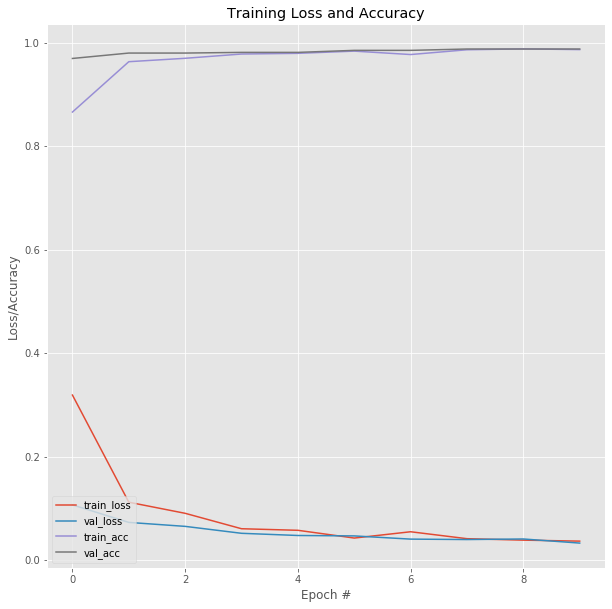

In [19]:
# plot the training loss and accuracy
N = epoch
plt.style.use("ggplot")
plt.figure(figsize=(10,10))
plt.plot(np.arange(0, N), Hist.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), Hist.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), Hist.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), Hist.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")